# Setting Up

In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import numpy as np
import pandas as pd

from scipy.special import softmax
from nltk.corpus import stopwords 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

# Functions

In [2]:
def cleanText(sentence):
    # remove punctuation
    sentence = re.sub(r'==.*?==+,:', '', sentence)
    sentence = sentence.replace('\n', '')

    # tokenize and remove stopwords
    token_words = word_tokenize(sentence)
    stop_words = set(stopwords.words('english'))
    token_words = [w for w in token_words if not w in stop_words]
    
    # stemming
    # porter = PorterStemmer()
    lancaster=LancasterStemmer()
    
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(lancaster.stem(word))
        stem_sentence.append(" ")
        
    return "".join(stem_sentence)

In [3]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [4]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [5]:
def class_type(label, pred):
    if label == 1:
        if pred == 0:
            return 'FN'
        else:
            return 'TP'
    else:
        if pred == 0:
            return 'TN'
        else:
            return 'FP'

# Word Cloud

In [6]:
# reading data
def gen_word_cloud(df, pred_class = 'FN'):
    # df = pd.read_csv(csv)
    
    # retrieve false negatives
    df_fn = pd.DataFrame(df.loc[df['class'] == pred_class])
    
    # retrieve text
    df_fn_text = ''
    for i in range(len(df_fn)):
        df_fn_text += df_fn.iloc[i]['text'] + ' '
    
    # clean text
    df_fn_text = cleanText(df_fn_text)
    
    # Generate word cloud
    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(df_fn_text)
    # Plot
    plot_cloud(wordcloud)

In [7]:
path = 'data/'
df = pd.read_csv(path+"roberta_base_prob.csv")
df['class'] = df.apply(lambda x: class_type(x.label, x.pred), axis=1)
df.head()

,date_time,source,entity,text,label,pred,raw_output_0,raw_output_1,prob,class
0,15/5/19 0:00,news,Coinbase,Fidelity Investments Seeks Talent for Its Digi...,0,0,1.523120,-1.725196,0.037387,TN
1,15/5/19 0:00,news,Coinbase,Crypto Custodians Foresee Growth in Partnershi...,0,0,1.531524,-1.747240,0.036307,TN
2,15/5/19 1:28,news,ENS,Blockchain-Based MVNO Miracle Tele To End Toke...,0,0,1.524287,-1.732396,0.037087,TN
3,16/5/19 0:00,news,Poloniex,Poloniex Stops Offering Nine Coins in US Due t...,0,0,1.496648,-1.702449,0.039200,TN
4,16/5/19 0:00,news,Gate.io,Can Bitcoin Win the Digital Payments Ã¢ÂÂGau...,0,0,1.512344,-1.718586,0.038018,TN


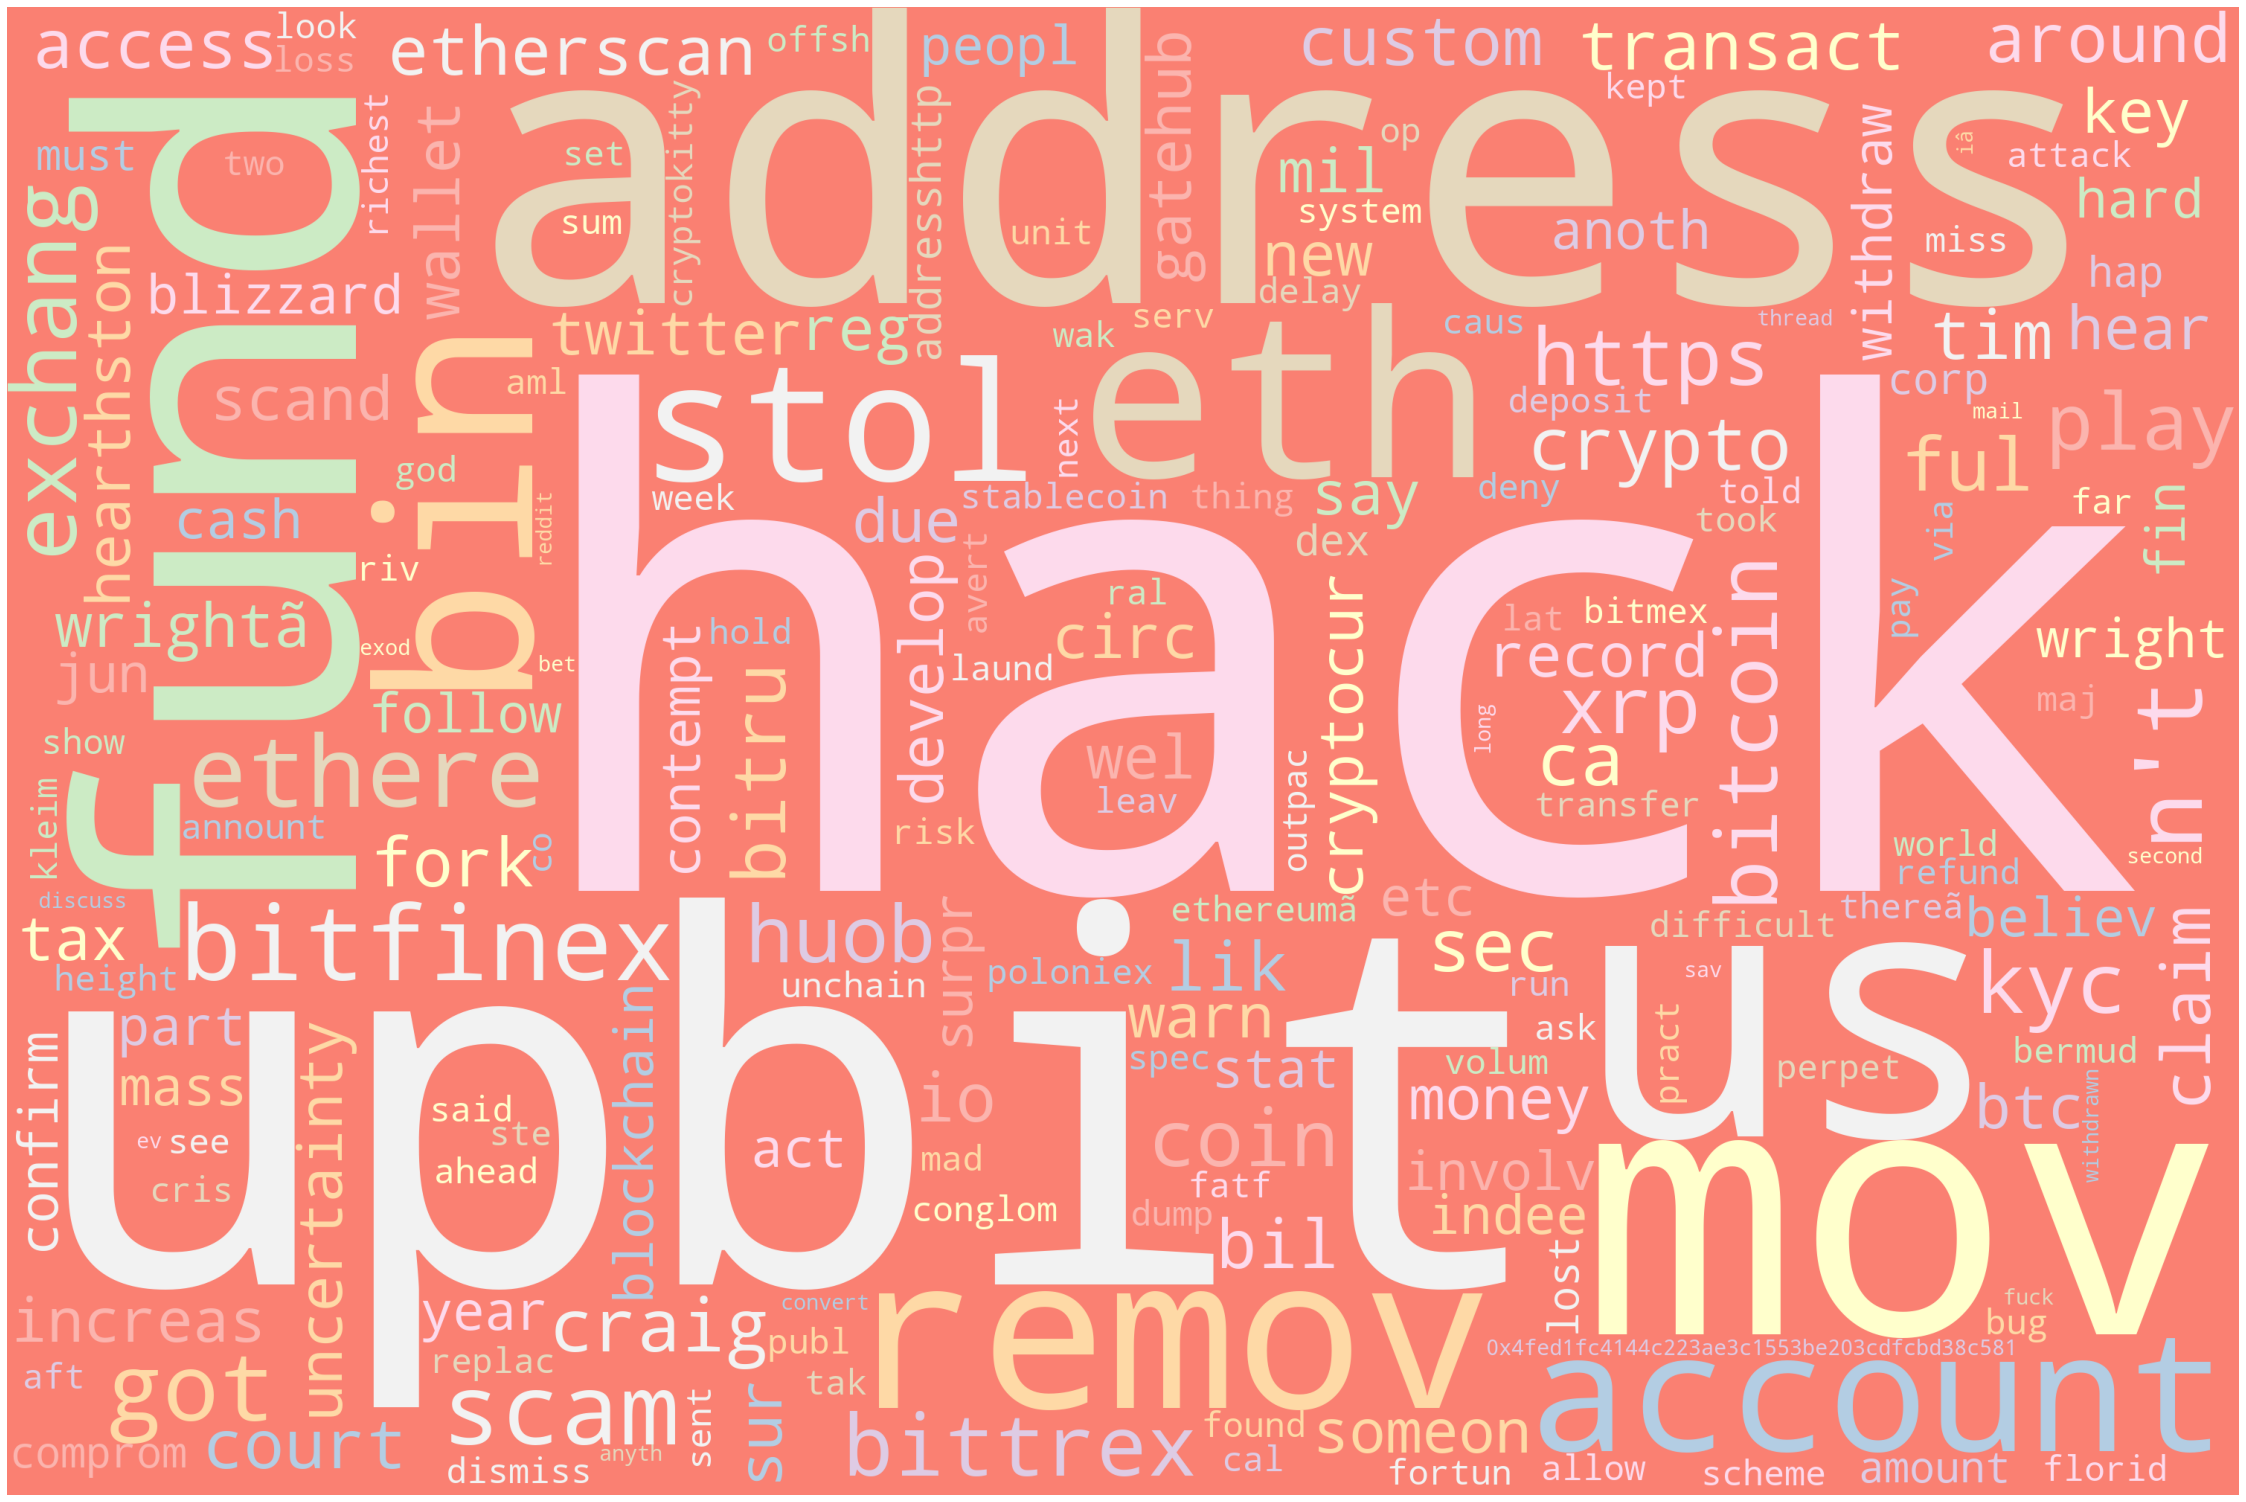

In [8]:
gen_word_cloud(df, "FN")
# gen_word_cloud(df, "FP")

In [9]:
df['source'].value_counts()

news       551
reddit     378
twitter     97
Name: source, dtype: int64

# Entity Word Counts

In [10]:
# reading data
bert = pd.read_csv(path+"roberta_base_test.csv")
bert['class'] = bert.apply(lambda x: class_type(x.label, x.pred), axis=1)
bert.head()

,date_time,source,entity,text,label,pred,raw_output_0,raw_output_1,class
0,15/5/19 0:00,news,Coinbase,Fidelity Investments Seeks Talent for Its Digi...,0,0,1.523120,-1.725196,TN
1,15/5/19 0:00,news,Coinbase,Crypto Custodians Foresee Growth in Partnershi...,0,0,1.531524,-1.747240,TN
2,15/5/19 1:28,news,ENS,Blockchain-Based MVNO Miracle Tele To End Toke...,0,0,1.524287,-1.732396,TN
3,16/5/19 0:00,news,Poloniex,Poloniex Stops Offering Nine Coins in US Due t...,0,0,1.496648,-1.702449,TN
4,16/5/19 0:00,news,Gate.io,Can Bitcoin Win the Digital Payments Ã¢ÂÂGau...,0,0,1.512344,-1.718586,TN


In [11]:
for c in ['TN', 'TP', 'FN', 'FP']:
    sample = bert.loc[bert['class'] == c]

    # retrieve text
    text = ''

    for i in range(len(sample)):
        text += sample.iloc[i]['text'] + ' '
    
    # clean text
    text = cleanText(text)
    # word count
    text_dict = word_count(text)

    if c == "TN":
        results = pd.DataFrame()
        results['word'] = list(text_dict.keys())
        results['count'] = list(text_dict.values())
    else:
        res = pd.DataFrame()
        res['word'] = list(text_dict.keys())
        res['count'] = list(text_dict.values())

        # merge
        results = results.merge(res, how='outer', on=['word'])

In [12]:
results = results.fillna(0)
results.columns = ['word', 'TN', 'TP', 'FN', 'FP']

In [13]:
entity_lst = list(pd.read_csv(path+"entity_list.csv")['entity'])
entity_lst = [x.lower() for x in entity_lst]

In [14]:
results_entity = pd.DataFrame(columns=['word', 'TN', 'TP', 'FN', 'FP'])
for e in entity_lst:
    results_entity = results_entity.append(results.loc[results['word'] == e])

In [15]:
results_entity

,word,TN,TP,FN,FP
3301,airswap,0.0,2.0,0.0,0.0
1994,antpool,1.0,0.0,0.0,0.0
2804,bitbox,2.0,0.0,0.0,0.0
1644,bitfinex,37.0,13.0,12.0,40.0
2550,bithumb,5.0,10.0,1.0,8.0
1731,bitstamp,5.0,0.0,0.0,0.0
1858,bittrex,32.0,10.0,8.0,1.0
2329,decentraland,1.0,0.0,0.0,0.0
316,dex,8.0,1.0,3.0,0.0
4061,dragonex,0.0,0.0,0.0,7.0


# Converting to Probabilities

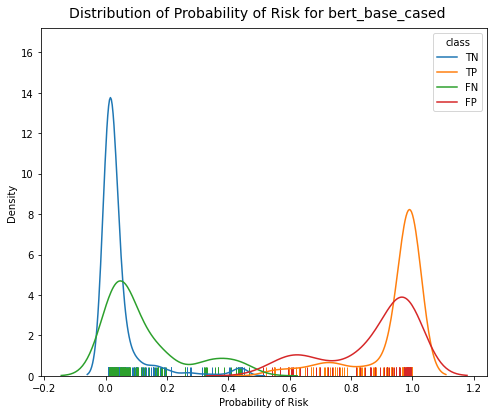

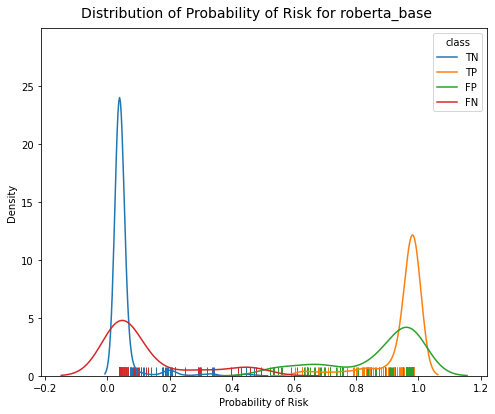

In [16]:
csvs = ["bert_base_cased", "roberta_base"]
csv_data = dict()

for csv in csvs:
    df = pd.read_csv(path+csv+"_test.csv")
    
    # convert raw outputs to probabilities
    raw_outputs = []
    
    for i in range(len(df)):
        row = df.iloc[i]
        raw_outputs.append([row['raw_output_0'], row['raw_output_1']])
        
    probabilities = softmax(raw_outputs, axis=1)
    
    # get probability of being classified as 1 = risky
    prob_risky = [x[1] for x in probabilities]
    
    df['prob'] = prob_risky
    
    # TP, TN, FP, FN
    df['class'] = df.apply(lambda x: class_type(x.label, x.pred), axis=1)
    
    csv_data[csv] = df
    
    # plot distribution
    fig, ax = plt.subplots(figsize = (8, 6))
    fig.subplots_adjust(top=0.93, wspace=0.3)
    title = fig.suptitle(f"Distribution of Probability of Risk for {csv}", fontsize=14)
    ax.set_ylabel("Density")
    ax.set_xlabel("Probability of Risk")
    
    sns.FacetGrid(df, hue="class").map(sns.distplot, 'prob', hist = False, rug = True, ax=ax)

    ax.legend(title='class')

    plt.close()

# Examining Optimal Threshold
- Bert & Roberta models return a raw output which can be converted into the probability of being classified as "1"
- By default, the model predicts the labels 0 or 1 with a threshold of 0.5
- This part of the code tries to find an optimal threshold by plotting a graph of % predicted as 'risky' against the threshold.

## Test Set

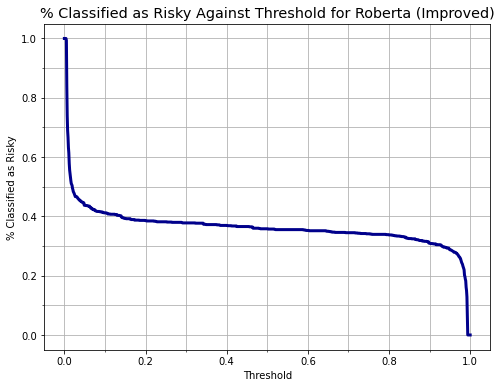

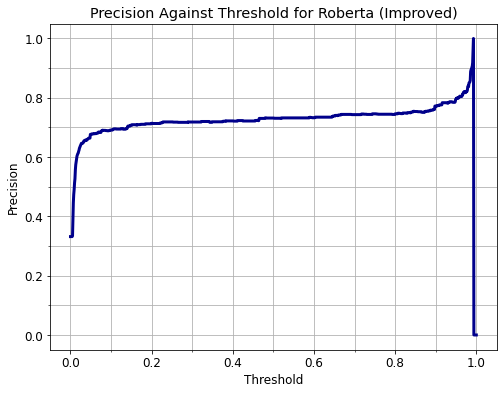

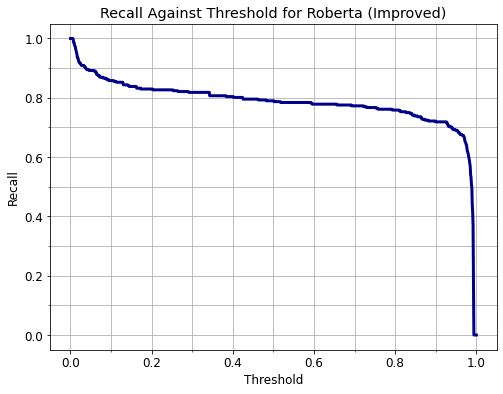

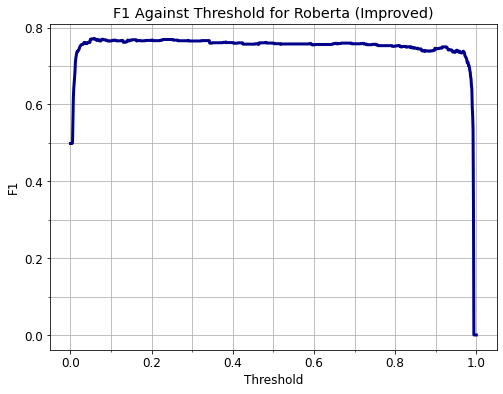

In [17]:
# models with output probabilities
# csv_lst = ["bert_base_cased", "roberta_base"]
csv_lst = [path+"hash_entity_url_roberta_all_test"]

# set range of threshold to search for
threshold_lst = np.arange(0, 1.001, 0.001)

f1_both = []
precision_both = []
recall_both = []
perc_risky_both = []

for csv in csv_lst:
    # data = pd.read_csv(csv+"_prob.csv")
    data = pd.read_csv(csv+".csv")
    n = len(data)
    
    y_true = data['label']
    
    # retrieve probability
    prob_lst = list(data['prob'])
    perc_risky_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    
    for threshold in threshold_lst:
        new_pred = [1 if p >= threshold else 0 for p in prob_lst]
        
        # calculate percentage risky
        num_risky = sum(new_pred)
        perc_risky_lst.append(num_risky)
        
        # calculate metrics
        report = classification_report(y_true=y_true, y_pred=new_pred, output_dict=True)['1']
        precision_lst.append(report['precision'])
        recall_lst.append(report['recall'])
        f1_lst.append(report['f1-score'])

    # convert num_risky to %
    perc_risky_lst = [(x / n) for x in perc_risky_lst]

    # save
    perc_risky_both.append(perc_risky_lst)
    precision_both.append(precision_lst)
    recall_both.append(recall_lst)
    f1_both.append(f1_lst)
    
    # plot
    y = [perc_risky_lst, precision_lst, recall_lst, f1_lst]
    y_lab = ["% Classified as Risky", "Precision", "Recall", "F1"]
    
    for i in range(len(y)):
        # set figure size
        fig, ax = plt.subplots(figsize=(8, 6))

        # set ticks
        major_ticks = np.arange(0, 1.3, 0.2)
        minor_ticks = np.arange(0, 1.1, 0.1)

        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_yticks(major_ticks)
        ax.set_yticks(minor_ticks, minor=True)

        # add gridlines
        ax.grid(which="both")

        # plot graph
        plt.plot(threshold_lst, y[i], color = 'darkblue', linewidth=3)

        # label graph
        plt.rcParams.update({'font.size': 12})
        plt.xlabel('Threshold')
        plt.ylabel(y_lab[i])
        plt.title(f'{y_lab[i]} Against Threshold for Roberta (Improved)' )
        plt.show()

### Precision and Recall Same Model

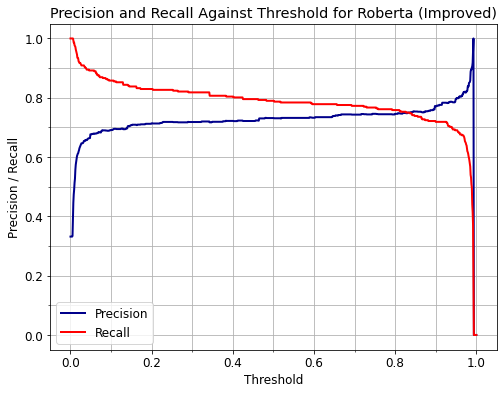

In [18]:
# y = [perc_risky_lst, precision_lst, recall_lst, f1_lst]
# y_lab = ["% Classified as Risky", "Precision", "Recall", "F1"]
    
# set figure size
fig, ax = plt.subplots(figsize=(8, 6))

# set ticks
major_ticks = np.arange(0, 1.3, 0.2)
minor_ticks = np.arange(0, 1.1, 0.1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# add gridlines
ax.grid(which="both")

# plot graph
plt.plot(threshold_lst, precision_lst, color = 'darkblue', linewidth=2, label='Precision')
plt.plot(threshold_lst, recall_lst, color = 'red', linewidth=2, label='Recall')
# plt.plot(threshold_lst, f1_lst, color = 'green', linewidth=2, label='F1')


# label graph
plt.rcParams.update({'font.size': 12})
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Precision and Recall Against Threshold for Roberta (Improved)' )
plt.legend()
plt.show()

## Train Set

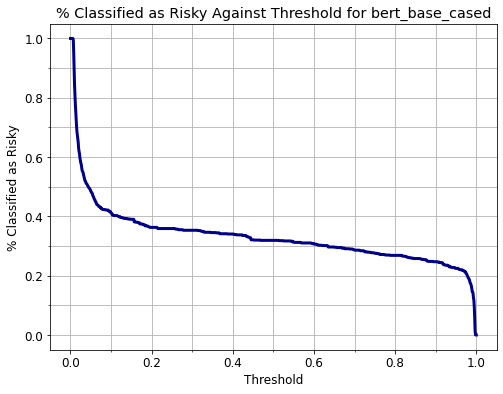

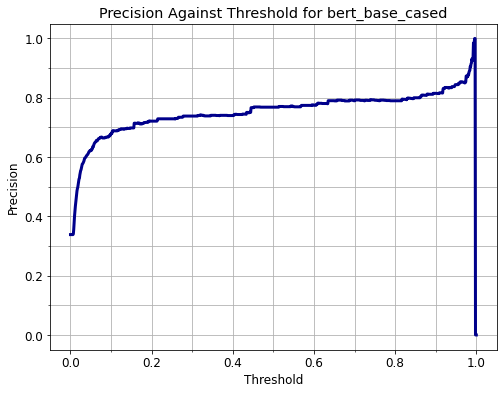

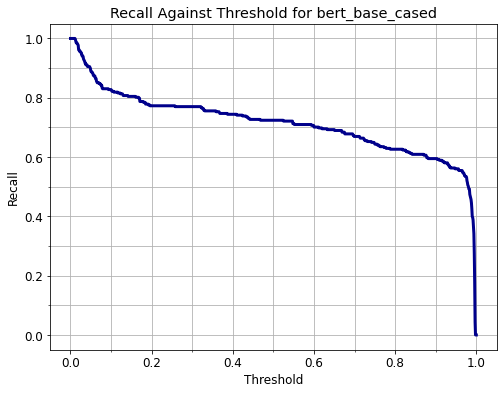

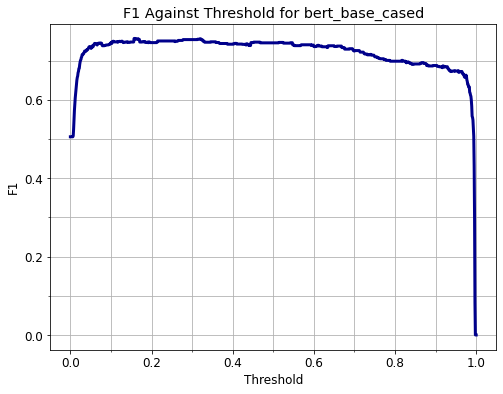

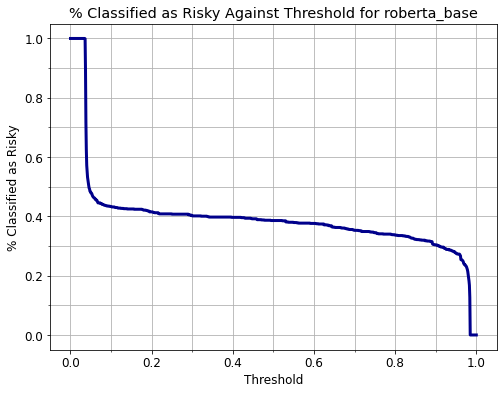

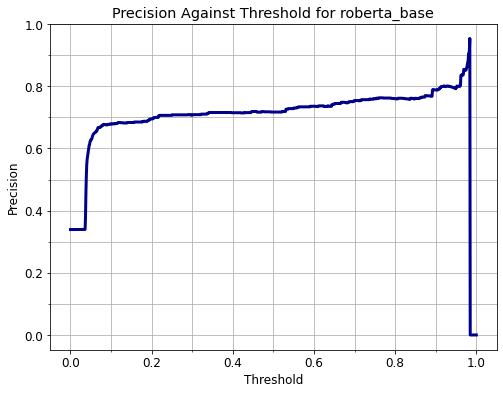

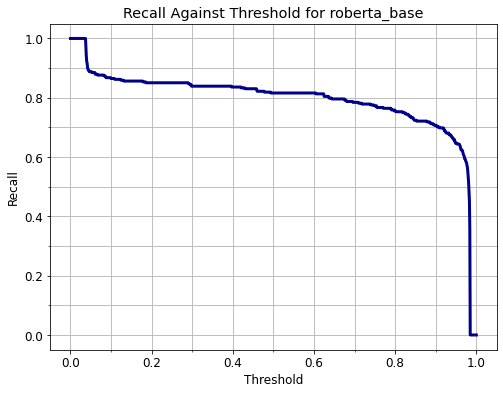

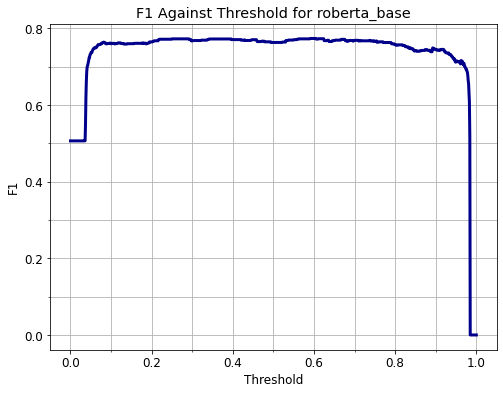

In [19]:
# set range of threshold to search for
threshold_lst = np.arange(0, 1.001, 0.001)

f1_both = []
precision_both = []
recall_both = []
perc_risky_both = []

for key, data in csv_data.items():
    # data = pd.read_csv(csv+"_prob.csv")
    n = len(data)
    
    y_true = data['label']
    
    # retrieve probability
    prob_lst = list(data['prob'])
    perc_risky_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    
    for threshold in threshold_lst:
        new_pred = [1 if p >= threshold else 0 for p in prob_lst]
        
        # calculate percentage risky
        num_risky = sum(new_pred)
        perc_risky_lst.append(num_risky)
        
        # calculate metrics
        report = classification_report(y_true=y_true, y_pred=new_pred, output_dict=True)['1']
        precision_lst.append(report['precision'])
        recall_lst.append(report['recall'])
        f1_lst.append(report['f1-score'])

    # convert num_risky to %
    perc_risky_lst = [(x / n) for x in perc_risky_lst]
    
    # save
    perc_risky_both.append(perc_risky_lst)
    precision_both.append(precision_lst)
    recall_both.append(recall_lst)
    f1_both.append(f1_lst)
    
    # plot
    y = [perc_risky_lst, precision_lst, recall_lst, f1_lst]
    y_lab = ["% Classified as Risky", "Precision", "Recall", "F1"]
    
    for i in range(len(y)):
        # set figure size
        fig, ax = plt.subplots(figsize=(8, 6))

        # set ticks
        major_ticks = np.arange(0, 1.3, 0.2)
        minor_ticks = np.arange(0, 1.1, 0.1)

        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_yticks(major_ticks)
        ax.set_yticks(minor_ticks, minor=True)

        # add gridlines
        ax.grid(which="both")

        # plot graph
        plt.plot(threshold_lst, y[i], color = 'darkblue', linewidth=3)

        # label graph
        plt.rcParams.update({'font.size': 12})
        plt.xlabel('Threshold')
        plt.ylabel(y_lab[i])
        plt.title(f'{y_lab[i]} Against Threshold for {key}' )
        plt.show()

### Precision and Recall Across Models

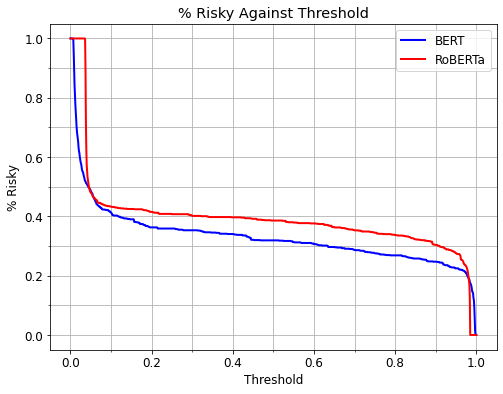

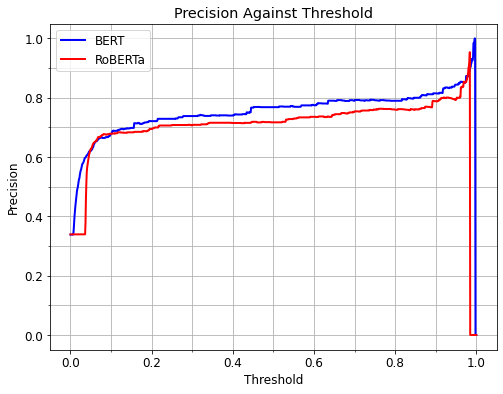

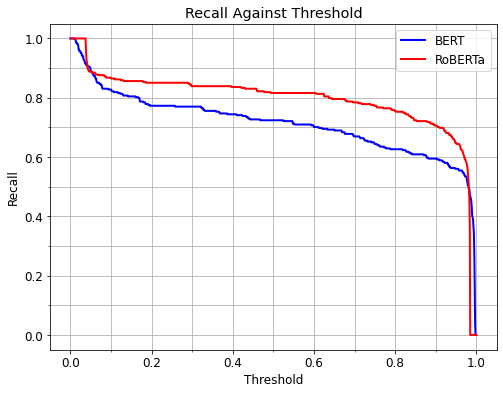

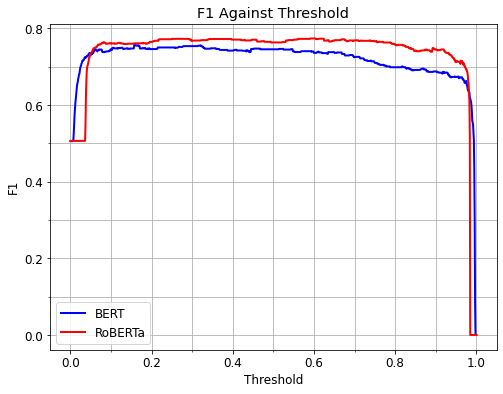

In [20]:
# y = [perc_risky_lst, precision_lst, recall_lst, f1_lst]
# y_lab = ["% Classified as Risky", "Precision", "Recall", "F1"]

label_both = ['BERT', 'RoBERTa']
colors = ['blue', 'red']
metrics = ['% Risky', 'Precision', 'Recall', 'F1']

count = 0
for metric_both in [perc_risky_both, precision_both, recall_both, f1_both]:
    # set figure size
    fig, ax = plt.subplots(figsize=(8, 6))

    # set ticks
    major_ticks = np.arange(0, 1.3, 0.2)
    minor_ticks = np.arange(0, 1.1, 0.1)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)

    # add gridlines
    ax.grid(which="both")

    # plot graph

    for i in range(len(metric_both)):
        plt.plot(threshold_lst, metric_both[i], color = colors[i], linewidth=2, label=label_both[i])

    # label graph
    plt.rcParams.update({'font.size': 12})
    plt.xlabel('Threshold')
    plt.ylabel(metrics[count])
    plt.title(f'{metrics[count]} Against Threshold' )
    plt.legend()
    plt.show()
    
    count += 1